Lecture: AI I - Advanced 

Previous:
[**Chapter 3.1: PyTorch Lightning**](../../03_advanced/01_ligthning.ipynb)

---

# Chapter 4.1.1: Computer Vision with Convolutional Neural Networks

In Chapter 2, PyTorch Lightning showed you how to organise and automate the training loop — separating data, model, and optimisation logic into clean, reusable blocks. You've been working with tabular data ever since the beginning: the Iris dataset, with its four numerical features per sample, fed directly into fully-connected layers.

Now we step into a completely different world: images. Images aren't rows of numbers in a table — they are grids of pixels, and the spatial arrangement of those pixels carries meaning. A stroke in the top-left corner of a digit and a stroke in the bottom-right corner together form a specific shape, but only because of where they are relative to each other. A fully-connected network has no way to exploit this structure. It sees a flat list of numbers and has to learn spatial relationships from scratch, which is expensive and wasteful.

This excursion introduces **Convolutional Neural Networks (CNNs)** — architectures specifically designed for grid-structured data like images. We start with the simplest possible image dataset, solve it first with a plain feedforward network to establish a baseline, and then build up to a CNN that is architecturally inspired by AlexNet, one of the models that kicked off the modern deep learning era.

## The MNIST Dataset

MNIST (Modified National Institute of Standards and Technology) is the "Hello World" of machine learning. It contains 70,000 handwritten digit images, each one a 28×28 pixel grayscale image of a single digit from 0 to 9.

| Property | Value |
|----------|-------|
| Training images | 60,000 |
| Test images | 10,000 |
| Image size | 28×28 pixels |
| Color channels | 1 (grayscale) |
| Classes | 10 (digits 0–9) |
| Pixel value range | 0 (Black) – 255 (White) |

Each image is stored as a 2D grid of pixel intensities. The digit "3", for example, is not defined by a single pixel value — it's defined by the pattern of bright pixels against a dark background. That pattern has structure: curves, lines, and their spatial relationships. This is exactly the kind of information that CNNs are built to capture.

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.80MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 332kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.12MB/s]


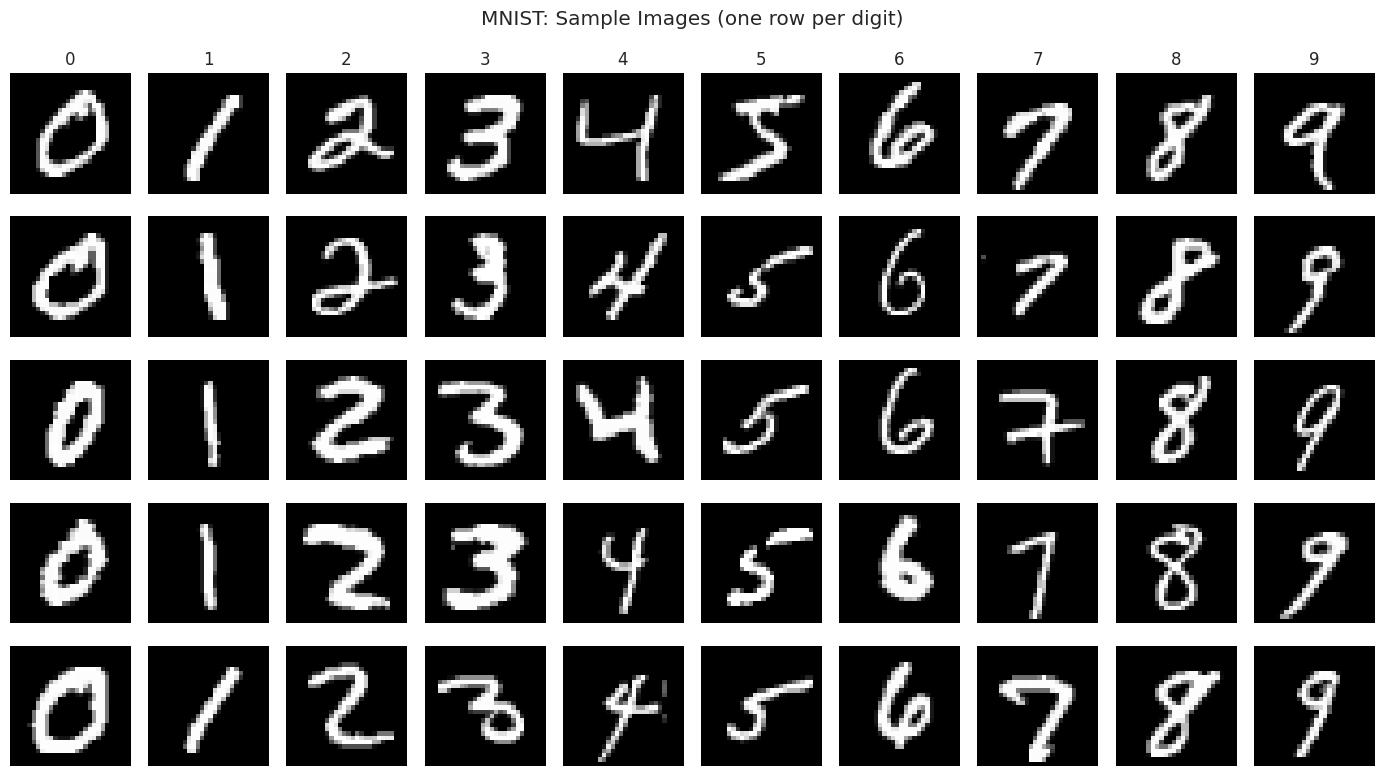

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),   # PIL Image (H, W) → Tensor (1, H, W), scales to [0, 1]
])

train_dataset = datasets.MNIST(root="./data/01_cnn", train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data/01_cnn", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(5, 10, figsize=(14, 8))

samples_per_digit = {d: [] for d in range(10)}
for img, label in train_dataset:
    if len(samples_per_digit[label]) < 5:
        samples_per_digit[label].append(img)
    if all(len(v) == 5 for v in samples_per_digit.values()):
        break

for row in range(5):
    for col in range(10):
        axes[row, col].imshow(samples_per_digit[col][row].squeeze(), cmap="gray")
        axes[row, col].axis("off")
        if row == 0:
            axes[row, col].set_title(str(col))

fig.suptitle("MNIST: Sample Images (one row per digit)")
fig.tight_layout()

## Solving MNIST with a Feedforward Network

Before we introduce CNNs, let's solve MNIST the "naive" way — with a plain feedforward network, the same architecture we've been using since Chapter 1. This gives us a baseline to compare against and makes the limitations of fully-connected layers on image data concrete.

### The Flatten Problem

A fully-connected (`nn.Linear`) layer expects a 1D vector as input. But our images are 2D grids (28×28). To feed an image into a Linear layer, we have to flatten it: reshape the 28×28 grid into a single vector of 784 numbers.

This works — the network can learn to classify digits from a flat vector — but it has to discover spatial patterns entirely from scratch, which requires more parameters and more data than necessary. CNNs solve this by operating directly on the 2D structure.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardClassifier(nn.Module):

    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super().__init__()
        self.flatten  = nn.Flatten()
        self.fc1      = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2      = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3      = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Instantiate and count parameters
model = FeedforwardClassifier()
total_params = sum(p.numel() for p in model.parameters())
print(f"Feedforward model parameters: {total_params:,}")

Feedforward model parameters: 269,322


### Training and Evaluation Helper

We'll reuse this helper for both the feedforward and CNN models so the comparison is fair.

In [14]:
import torch

def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train a model and return history + final test accuracy."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses,  test_accs  = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            logits = model(images)
            loss   = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            correct    += (logits.argmax(dim=1) == labels).sum().item()
            total      += images.size(0)

        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        model.eval()
        eval_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                logits = model(images)
                loss   = criterion(logits, labels)

                eval_loss += loss.item() * images.size(0)
                correct   += (logits.argmax(dim=1) == labels).sum().item()
                total     += images.size(0)

        test_losses.append(eval_loss / total)
        test_accs.append(correct / total)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}  Acc: {train_accs[-1]:.4f} | "
              f"Test Loss:  {test_losses[-1]:.4f}  Acc: {test_accs[-1]:.4f}")

    return {
        "train_loss": train_losses, "train_acc": train_accs,
        "test_loss":  test_losses,  "test_acc":  test_accs,
    }


history = train_and_evaluate(model, train_loader, test_loader, epochs=10)

Epoch  1/10 | Train Loss: 0.1127  Acc: 0.9664 | Test Loss:  0.0850  Acc: 0.9743
Epoch  2/10 | Train Loss: 0.0896  Acc: 0.9719 | Test Loss:  0.0751  Acc: 0.9761
Epoch  3/10 | Train Loss: 0.0782  Acc: 0.9757 | Test Loss:  0.0816  Acc: 0.9746
Epoch  4/10 | Train Loss: 0.0686  Acc: 0.9785 | Test Loss:  0.0656  Acc: 0.9790
Epoch  5/10 | Train Loss: 0.0646  Acc: 0.9792 | Test Loss:  0.0667  Acc: 0.9810
Epoch  6/10 | Train Loss: 0.0555  Acc: 0.9819 | Test Loss:  0.0693  Acc: 0.9798
Epoch  7/10 | Train Loss: 0.0550  Acc: 0.9822 | Test Loss:  0.0650  Acc: 0.9817
Epoch  8/10 | Train Loss: 0.0500  Acc: 0.9842 | Test Loss:  0.0722  Acc: 0.9783
Epoch  9/10 | Train Loss: 0.0481  Acc: 0.9842 | Test Loss:  0.0726  Acc: 0.9797
Epoch 10/10 | Train Loss: 0.0446  Acc: 0.9853 | Test Loss:  0.0638  Acc: 0.9828


## Why Feedforward Networks Are Wasteful on Images

Before we move to CNNs, let's make the problem concrete. Look at what happens when you flatten an image and feed it into a fully-connected layer:

**Parameter explosion**: The first Linear layer alone needs 784 × 256 = 200,704 weights. Every single input pixel is connected to every single neuron. Most of these connections are meaningless — pixel [0, 0] (top-left corner) has nothing to do with pixel [27, 27] (bottom-right corner), but the network dedicates a learnable weight to their connection anyway.

**No spatial awareness**: After flattening, the network treats the pixel sequence as arbitrary. If you permuted the pixels randomly (shuffled their positions), the network would need to relearn everything from scratch. A CNN, by contrast, would break immediately — because it relies on spatial structure.

**No weight sharing**: The same visual pattern (say, a curved stroke) can appear anywhere in the image. A fully-connected layer learns a separate set of weights for detecting that pattern at each position. A CNN uses the same weights everywhere — a huge efficiency gain.

This is the motivation for convolutions. They are not just "another layer type" — they are a fundamentally different way of processing grid-structured data.

---

Lecture: AI I - Advanced 

Exercise: [**Exercise 2.1: Python Basics**](../02_python/exercises/01_basics.ipynb)

Next: [**Chapter 4.2.1: Transformers**](../02_nlp/01_gpt2.ipynb)